<a href="https://colab.research.google.com/github/Davidjr2889/Davidjr2889/blob/main/Keagle_melbourne_property_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd


from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [3]:
data = pd.read_csv('MELBOURNE_HOUSE_PRICES_LESS.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18220 entries, 0 to 18219
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         18220 non-null  object 
 1   Address        18220 non-null  object 
 2   Rooms          18220 non-null  int64  
 3   Type           18220 non-null  object 
 4   Price          13976 non-null  float64
 5   Method         18220 non-null  object 
 6   SellerG        18220 non-null  object 
 7   Date           18220 non-null  object 
 8   Postcode       18220 non-null  int64  
 9   Regionname     18220 non-null  object 
 10  Propertycount  18219 non-null  float64
 11  Distance       18219 non-null  float64
 12  CouncilArea    18219 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 1.8+ MB


In [5]:
#preprocessamento

In [6]:
def onehot_encode(df, column_dict):
  df = df.copy()

  for column, prefix in column_dict.items():
    dummies = pd.get_dummies(df[column], prefix= prefix)
    df = pd.concat([df, dummies], axis= 1)
    df = df.drop(column, axis=1)
  return df

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

Criar um espaço para alocar o endereço o qual será categorizado.

In [49]:
def get_sequences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    
    vocab_length = len(tokenizer.word_index) + 1
    print("Vocab length:", vocab_length)
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    max_seq_length = np.max([len(sequence) for sequence in sequences])
    print("Max sequence length:", max_seq_length)
    
    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    return sequences

In [50]:
get_sequences(X['Address'])

KeyError: ignored

In [52]:
pd.get_dummies(data['Method'])

,PI,PN,S,SA,SN,SP,SS,VB,W
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
63018,0,0,1,0,0,0,0,0,0
63019,0,0,1,0,0,0,0,0,0
63020,0,0,1,0,0,0,0,0,0
63021,1,0,0,0,0,0,0,0,0


In [51]:
def preprocess_inputs(df):
  df = df.copy()
  #tirando linhas com valores vazios

  df = df.dropna(axis = 0 ).reset_index(drop=True)

  #one-hotencoder

  column_dict = {
      'Suburb': 'SU',
      'Type': 'TY',  
      'Method': 'ME',   
      'SellerG': 'SE', 
      'Postcode': 'PO',   
      'Regionname': 'RE',
      'CouncilArea': 'CO',
  }
 
  df = onehot_encode(df, column_dict)

  # Reemplazando Data por --- Ano, Mes, e dia com metodo lambda
  df['Date'] = pd.to_datetime(df['Date'])

  df['Year'] = df['Date'].apply(lambda x: x.year)
  df['Month'] = df['Date'].apply(lambda x: x.month)
  df['Day'] = df['Date'].apply(lambda x: x.day)

  df = df.drop('Date', axis=1)

  #obter sequencias de endereços

  addr_sequences = get_sequences(df['Address'])
  df = df.drop('Address', axis = 1)

  # Decl
  y = df['Price'].copy()
  X = df.drop('Price', axis = 1).copy()

  # escalando X com um escalador standar "scale"
  scaler = StandardScaler()
  X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



  return X, addr_sequences, y


In [52]:
X, addr_sequences, y = preprocess_inputs(data)

Vocab length: 6236
Max sequence length: 5


In [25]:
X.mean()


Rooms                           -2.279965e-15
Propertycount                   -4.774753e-17
Distance                        -3.504333e-16
SU_Abbotsford                    1.014366e-15
SU_Aberfeldie                    1.899837e-15
                                     ...     
CO_Yarra City Council           -3.279027e-15
CO_Yarra Ranges Shire Council   -9.722485e-16
Year                            -1.442532e-13
Month                            6.036992e-14
Day                              2.863144e-15
Length: 907, dtype: float64

In [23]:
addr_sequences

array([[  61, 2005,    1,    0,    0],
       [2006,  641,    1,    0,    0],
       [3256,  347,    1,    0,    0],
       ...,
       [   8, 1276,  155,    2,    0],
       [  23,   28,  116,    2,    0],
       [  15,   29, 3208,  878,    2]], dtype=int32)

In [120]:
y

0        1490000.0
1        1220000.0
2        1420000.0
3        1515000.0
4         670000.0
           ...    
48428     347700.0
48429     808000.0
48430     566000.0
48431     500000.0
48432     545000.0
Name: Price, Length: 48433, dtype: float64

In [29]:
X_train, X_test, addr_train, addr_test, y_train, y_test = train_test_split(X, addr_sequences, y, train_size=0.7, random_state=123)

In [33]:
addr_train.shape

(9782, 5)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_input (InputLayer)           [(None, 907)]        0           []                               
                                                                                                  
 addr_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 X_dense1 (Dense)               (None, 512)          464896      ['X_input[0][0]']                
                                                                                                  
 addr_embebing (Embedding)      (None, 5, 64)        399104      ['addr_input[0][0]']             
                                                                                            

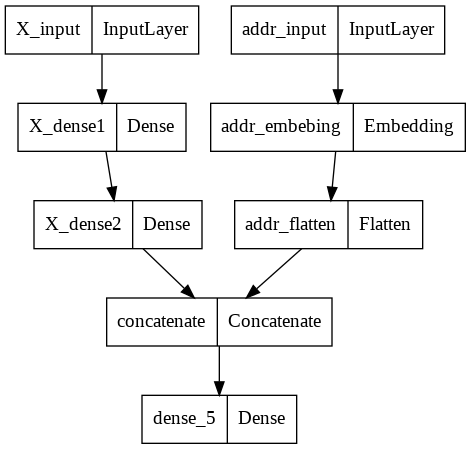

In [48]:
X_inputs = tf.keras.Input(shape=(X_train.shape[1],), name= 'X_input')
addr_inputs = tf.keras.Input(shape=(addr_train.shape[1],), name='addr_input')

X_dense1 = tf.keras.layers.Dense(512, activation = 'relu', name = 'X_dense1')(X_inputs)
X_dense2 = tf.keras.layers.Dense(512, activation = 'relu', name = 'X_dense2')(X_dense1)

addr_embebing = tf.keras.layers.Embedding(
    input_dim = 6236,
    output_dim = 64,
    input_length = addr_train.shape[1],
    name= 'addr_embebing'
) (addr_inputs)
addr_flatten = tf.keras.layers.Flatten(name='addr_flatten')(addr_embebing)

concat = tf.keras.layers.concatenate([X_dense2, addr_flatten],name = 'concatenate' )

outputs = tf.keras.layers.Dense(1, activation = 'linear')(concat)
model = tf.keras.Model(inputs= [X_inputs, addr_inputs], outputs=outputs)


print(model.summary())
tf.keras.utils.plot_model(model)

In [57]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.1),
    loss= 'mse'
)

history = model.fit(
    [X_train, addr_train],
    y_train,
    validation_split= 0.2,
    batch_size = 32,
    epochs = 50,
    callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience = 3,
                    restore_best_weights = True
                ),
                tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50
245/245 [==============================] - 4s 14ms/step - loss: 76707143680.0000 - val_loss: 126206189568.0000 - lr: 0.1000
Epoch 2/50
245/245 [==============================] - 3s 13ms/step - loss: 68558262272.0000 - val_loss: 116755349504.0000 - lr: 0.1000
Epoch 3/50
245/245 [==============================] - 3s 13ms/step - loss: 61633462272.0000 - val_loss: 126749163520.0000 - lr: 0.1000
Epoch 4/50
245/245 [==============================] - 3s 12ms/step - loss: 57326149632.0000 - val_loss: 119926890496.0000 - lr: 0.1000
Epoch 5/50
245/245 [==============================] - 3s 13ms/step - loss: 53413183488.0000 - val_loss: 131006939136.0000 - lr: 0.1000


In [59]:
y_true = np.array(y_test)
y_pred = np.squeeze(model.predict([X_test, addr_test]))

In [60]:
model_r2 = r2_score(y_true, y_pred)
print('Model R*2 Score: {: 6f}', format(model_r2))

Model R*2 Score: {: 6f} 0.704622821633655
